In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import math
import seaborn as sns
sns.set_style("whitegrid")

In [28]:
#reduced chi2 calculations
def redchi2(f, x, y, y_err, *args):
    sum = 0
    for i in range(len(x)):
        sum += np.square((f(x[i], *args) - y[i])/(y_err[i]))
    dof = len(y) - len(args)
    rc2 = (sum)/dof
    return rc2

In [29]:
#coeff of determination: R^2
def R2(f, x, y, y_err, *args):
    ybar=np.mean(y)
    ss_tot = np.sum((y-ybar)**2)
    ss_res = np.sum((y-f(x, *args))**2)
    Rsq = 1-(ss_res/ss_tot)
    return Rsq

In [30]:
df = pd.read_csv('../data/unattpowvsattpow.csv',delimiter=',', header=0)
#read all columns data into variables
current = np.array(df['I (mA)'])
current_error = np.array(df['delta I'])
unatt_pow = np.array(df['Pnoatt [muW]'])
unatt_pow_error = np.array(df['delta Pnoatt'])
att_pow = np.array(df['Patt [muW]'])
att_pow_error = np.array(df['delta Patt'])

## Calibration of Attenuator

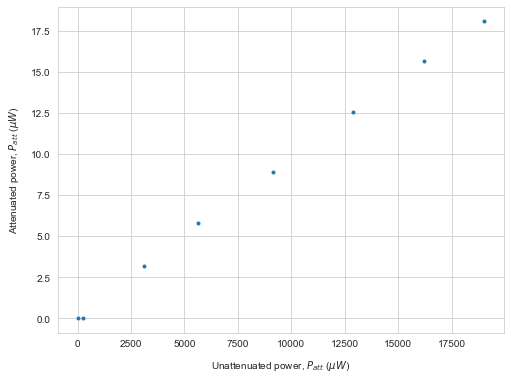

In [31]:
#Slicing req values
unatt_pow_cut = unatt_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_cut = att_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
unatt_pow_error_cut = unatt_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_error_cut = att_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
plt.figure(figsize=(8, 6))
plt.ylabel(r"Attenuated power, $P_{att}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Unattenuated power, $P_{att}$ ($\mu W$)", labelpad=10)

plt.plot(unatt_pow_cut, att_pow_cut,'.')
plt.show()

### Model for linear fit of attenuated power vs unattenuated power:

$P_{att}=aP_{unatt}+b$

In [32]:
def linear_model(x, a, b):
    return (a*x+b)

In [33]:
#Fit curve using some guess values for a and b
#popt stores optimal parameters
'''
pcov stores covariance matrix
Diagonal entries of cov matrix are variances of fit parameters
Sqrt(diag(pcov)) will give error (std dev) of fit paramaters
'''
popt, pcov = curve_fit(linear_model, unatt_pow_cut, att_pow_cut, sigma = att_pow_error_cut, p0=[1/1000,0], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1])


Optimal parameters: a= 0.0009947484183711964 b= -0.01635953514068112
Errors in optimal parameters: delta_a= 1.252530749933867e-06 delta_b= 0.006436979200177107


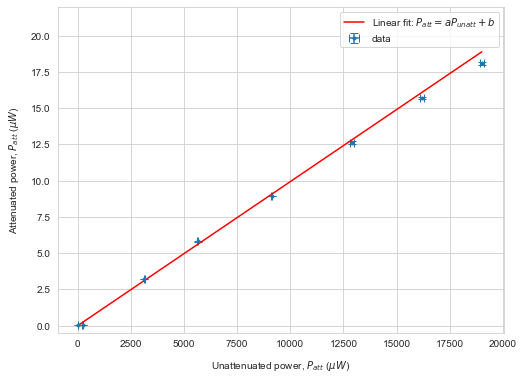

In [34]:
a_opt, b_opt = popt
a_err, b_err = perr
x_model = np.linspace(min(unatt_pow_cut), max(unatt_pow_cut), 1000)
y_model = linear_model(x_model, a_opt, b_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-0.5, 22)
#plt.xlabel(r"Unattenuated power, $P_{unatt}$ ($\mu W$)")
#plt.ylabel(r"Attenuated power, $P_{att}$ ($\mu W$)")
plt.errorbar(unatt_pow_cut, att_pow_cut, yerr = att_pow_error_cut, xerr = unatt_pow_error_cut, fmt = ".", label = 'data', capsize = 4)
plt.ylabel(r"Attenuated power, $P_{att}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Unattenuated power, $P_{att}$ ($\mu W$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"Linear fit: $P_{att}=aP_{unatt}+b$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/attvsunattcalib.pdf')
plt.show()

In [35]:
print(redchi2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

174.69104360771198


In [36]:
print(R2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

0.9972889507581929


## Dependence of Laser Power on Inj. Current

### Calculate unattenuated power from attenuated power for higher values using calibration factor

$P_{unatt}=\dfrac{P_{att}-b}{a}$

$\Delta P_{unatt}=\sqrt{\left(\dfrac{\Delta P_{att}}{a}\right)^{2}+\left(\dfrac{\Delta b}{a}\right)^{2}+\left(\dfrac{\Delta a(P_{att}-b)}{a^{2}}\right)^{2}}$

In [37]:
#Slicing req values
unatt_pow_cut = unatt_pow[current>=90]
att_pow_cut = att_pow[current>=90]
unatt_pow_error_cut = unatt_pow_error[current>=90]
att_pow_error_cut = att_pow_error[current>=90]
unatt_pow_cut = np.round((att_pow_cut-b_opt)/a_opt)
delta1 = (att_pow_error_cut/a_opt)**2
delta2 = (b_err/a_opt)**2
delta3 = ((a_err*(att_pow_cut-b_opt))/(a_opt**2))**2
unatt_pow_error_cut = np.round(np.sqrt(delta1+delta2+delta3))
print(unatt_pow_cut)
print(unatt_pow_error_cut)

[ 21730.  25048.  28064.  30879.  33995.  36508.  40630.  43847.  47064.
  49778.  53095.  56212.  60132.  63249.  65058.  68476.  71190.  74709.
  76820.  80740.  84661.  86470.  89888.  93608.  99137.  98534. 100544.
 106576. 109592. 109592. 114618. 117634. 120650. 121655. 125676. 132713.
 134724. 134724. 141761.]
[104. 106. 107. 108. 109. 111. 113. 115. 117. 119. 121. 123. 126. 128.
 130. 133. 135. 138. 140. 143. 147. 148. 152. 155. 160. 160. 162. 520.
 521. 521. 523. 524. 525. 526. 527. 530. 531. 531. 533.]


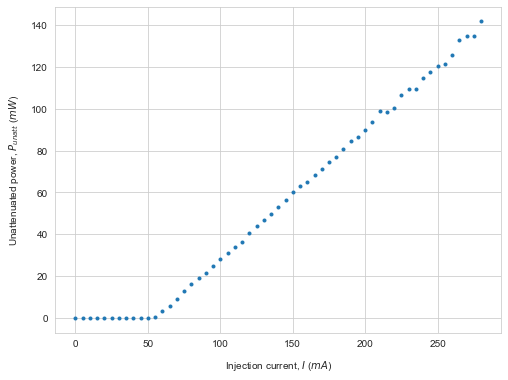

In [38]:
df = pd.read_csv('../data/unattpowvsattpow2.csv',delimiter=',', header=0)
#read all columns data into variables
current = np.array(df['I (mA)'])
current_error = np.array(df['delta I'])
unatt_pow = np.array(df['Pnoatt [muW]'])/1000
unatt_pow_error = np.array(df['delta Pnoatt'])/1000
att_pow = np.array(df['Patt [muW]'])/1000
att_pow_error = np.array(df['delta Patt'])/1000
plt.figure(figsize=(8, 6))
plt.xlabel(r"Injection current, $I$ ($mA$)", labelpad=10)
plt.ylabel(r"Unattenuated power, $P_{unatt}$ ($mW$)", labelpad=10)
plt.plot(current, unatt_pow,'.')
plt.show()

In [39]:
current_cut = current[(current>50)]
current_error_cut = current_error[(current>50)]
unatt_pow_cut = unatt_pow[(current>50)]
unatt_pow_error_cut = unatt_pow_error[(current>50)]
att_pow_cut = att_pow[(current>50)]
att_pow_error_cut = att_pow_error[(current>50)]

### Fitting the Injection current vs unattenuated power plot (only in linear region)

In [40]:
popt, pcov = curve_fit(linear_model, current_cut, unatt_pow_cut, sigma = unatt_pow_error_cut, p0=[30/40,-30], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1])

Optimal parameters: a= 0.6223378341101906 b= -34.328878809989675
Errors in optimal parameters: delta_a= 0.0002686873965431595 delta_b= 0.022152721610825963


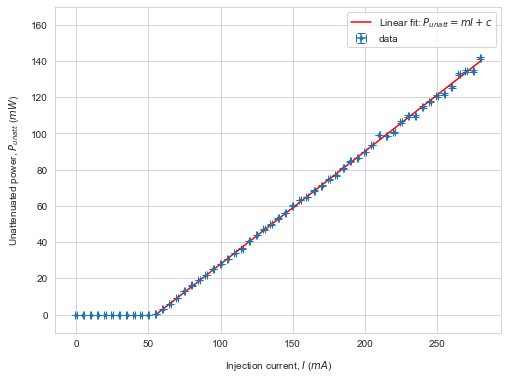

In [41]:
a_opt, b_opt = popt
a_err, b_err = perr
x_model = np.linspace(min(current_cut), max(current_cut), 1000)
y_model = linear_model(x_model, a_opt, b_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-10, 170)
plt.errorbar(current, unatt_pow, yerr = unatt_pow_error, xerr = current_error, fmt = ".", label = 'data', capsize = 4)
plt.xlabel(r"Injection current, $I$ ($mA$)", labelpad=10)
plt.ylabel(r"Unattenuated power, $P_{unatt}$ ($mW$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"Linear fit: $P_{unatt}=mI+c$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/injcvsunattpow.pdf')
plt.show()

In [42]:
print("Reduced chi sqaured =", redchi2(linear_model, current_cut, unatt_pow_cut, unatt_pow_error_cut, popt[0], popt[1]))
print("R^2 =", R2(linear_model, current_cut, unatt_pow_cut, unatt_pow_error_cut, popt[0], popt[1]))

Reduced chi sqaured = 44.79372378590967
R^2 = 0.9993398099952714


### Threshold Current:
$I_{0}=-\dfrac{c}{m}$

$\Delta I_{0}=\sqrt{\left(\dfrac{\Delta c}{m}\right)^{2}+\left(\dfrac{c \Delta m}{m}\right)^{2}}$


In [43]:
I0 = -popt[1]/popt[0]
delta1 = (perr[1]/popt[0])**2
delta2 = ((popt[1]*perr[0])/popt[0])**2
I0_err = np.sqrt(delta1+delta2)
print("I0=",I0)
print("Delta I0=", I0_err)

I0= 55.161163163207966
Delta I0= 0.03855825041341215


### Differential Slope Efficiency:

$\dfrac{\partial P}{\partial I}=\dfrac{P}{I}=m$

$\Delta \left(\dfrac{\partial P}{\partial I}\right)=\Delta m$

Same as slope $m$

### Quantum Differential Efficiency:

$\eta=\dfrac{N_{\gamma}}{N_{e}}=\dfrac{e}{h \nu}\dfrac{\partial P}{\partial I}$

$\Delta \eta=\dfrac{N_{\gamma}}{N_{e}}=\left(\dfrac{e}{h \nu}\right)\Delta\left(\dfrac{\partial P}{\partial I}\right)$

In [44]:
e = 1.602e-19
h = 6.626e-34
c = 3e8
wavelength = 987e-9
nu = c/wavelength
print("nu=",nu)
prefact = e/(h*nu)
eta = prefact*popt[0]
print("eta=",eta)
eta_err = prefact*perr[0]
print("delta eta=",eta_err)

nu= 303951367781155.0
eta= 0.49503189582017637
delta eta= 0.00021372448211174854


## Calibration of Variable Attenuator

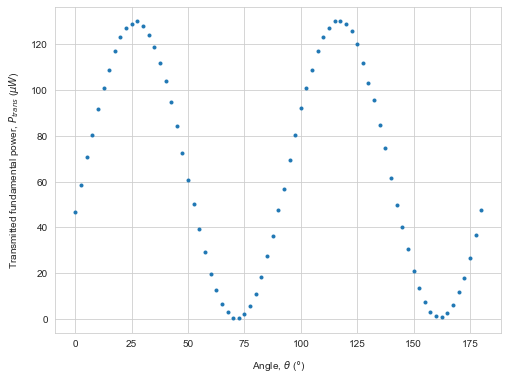

In [45]:
df = pd.read_csv('../data/variableattcalib.csv',delimiter=',', header=0)
#read all columns data into variables
theta = np.array(df['theta'])
theta_err = np.array(df['delta theta'])
att_pow = np.array(df['P [muW]'])
att_pow_err = np.array(df['delta P'])
plt.figure(figsize=(8, 6))
plt.ylabel(r"Transmitted fundamental power, $P_{trans}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Angle, $\theta$ ($\degree$)", labelpad=10)
plt.plot(theta, att_pow,'.')
plt.show()

### $\cos^{2}\theta$ fit model:

$P_{att}=a+b\cos^{2}\left(\dfrac{\pi}{180}c(\theta-\theta_{0})\right)$

In [46]:
def cossq_model(theta, a, b, c, theta_0):
    angle = (np.pi/180)*c*(theta-theta_0)
    part = b*((np.cos(angle))**2)
    cossq = a + part
    return cossq

### Fitting attenuated power with $\cos^{2}\theta$ model:

In [47]:
popt, pcov = curve_fit(cossq_model, theta, att_pow, sigma = att_pow_err, p0=[0,130,2,0], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1],"c=",popt[2],"theta_0=",popt[3])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1],"delta_c=",perr[2],"delta_theta_0=",perr[3])

Optimal parameters: a= 0.540552646080282 b= 129.56148732491454 c= 1.9983039375158596 theta_0= 26.590302221641803
Errors in optimal parameters: delta_a= 0.10153833917733412 delta_b= 0.1674553302142639 delta_c= 0.0006836214225836751 delta_theta_0= 0.027361810498780087


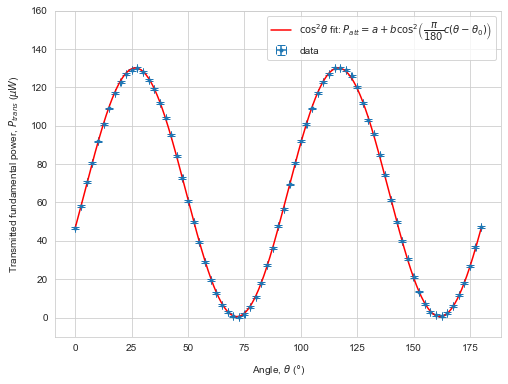

In [48]:
a_opt, b_opt, c_opt, theta_0_opt = popt
a_err, b_err, c_err, theta_0_err = perr
x_model = np.linspace(min(theta), max(theta), 1000)
y_model = cossq_model(x_model, a_opt, b_opt, c_opt, theta_0_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-10, 160)
plt.errorbar(theta, att_pow, yerr = att_pow_err, xerr = theta_0_err, fmt = ".", label = 'data', capsize = 4)
plt.ylabel(r"Transmitted fundamental power, $P_{trans}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Angle, $\theta$ ($\degree$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"$\cos^{2}\theta$ fit: $P_{att}=a+b\cos^{2}\left(\dfrac{\pi}{180}c(\theta-\theta_{0})\right)$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/variabattcalib.pdf')
plt.show()

In [49]:
print("Reduced chi squared =", redchi2(cossq_model, theta, att_pow, att_pow_err, popt[0], popt[1], popt[2], popt[3]))

Reduced chi squared = 1.4696915496359466


### Extinction ratio:

$\eta_{ext}=\dfrac{P_{max}}{P_{min}}$

$\Delta \eta_{ext}=\sqrt{\left(\dfrac{\Delta b}{a}\right)^{2}+\left(\dfrac{b\Delta a}{a^{2}}\right)^{2}}$

In [50]:
eta_ext = (a_opt + b_opt)/a_opt
print("Extinction ratio=",eta_ext)
print("Extinction ratio in dB=",10*math.log10(eta_ext))
del1 = (b_err/a_opt)**2
del2 = ((b_opt*a_err)/(a_opt**2))**2
eta_ext_err = np.sqrt(del1+del2)
print("Error in ext. ratio:",eta_ext_err)

Extinction ratio= 240.68338378214557
Extinction ratio in dB= 23.8144610863474
Error in ext. ratio: 45.023604990350634


### Calculation of beam parameters:

##### Beam waist: $\omega_{0}=\dfrac{2f\lambda}{\pi d}$
##### Beam waist error: $\Delta \omega_{0}=\dfrac{2f\lambda}{\pi}\left(\dfrac{\Delta d}{d}\right)$

##### Rayleight length: $z_{0}=\dfrac{\pi n \omega_{0}^{2}}{\lambda}$
##### Rayleight length err: $\Delta z_{0}=\dfrac{2\pi n \omega_{0}\Delta \omega_{0}}{\lambda}$

##### Confocal parameter: $b=2z_{0}$
##### Confocal parameter err: $\Delta b=2\Delta z_{0}$

##### Boyd Kleinmann Condition: $\dfrac{L}{b}=2.84$
##### Boyd Kleinmann Condition err: $\Delta \left(\dfrac{L}{b}\right)=\dfrac{L\Delta b}{b^{2}}$

##### Optimal focal length: $f_{opt}=\sqrt{\dfrac{\pi d^{2}L}{24.616n\lambda}}$
##### Optimal focal length err: $\Delta f_{opt}=\sqrt{\dfrac{\pi L}{24.616n\lambda}}\Delta d$

In [51]:
f = 60
L=5
n=2.2
lamb = 987e-6
d= 3.5
d_err = 0.5
omega_0 = (2*f*lamb)/(np.pi*d)
omega_0_err = omega_0*d_err
z_0 = np.pi*n*(omega_0**2)/lamb
z_0_err = (np.pi*n*omega_0*omega_0_err)/lamb
b= 2*z_0
b_err = 2*z_0_err
boyd = L/b
boyd_err = (L*b_err)/(b**2)
f_opt = np.sqrt((np.pi*(d**2)*L)/(24.616*n*lamb))
f_opt_err = np.sqrt((np.pi*L)/(24.616*n*lamb))*d_err

In [52]:
print('Beam waist:',omega_0,'+-',omega_0_err)
print('Rayleigh length:',z_0,'+-',z_0_err)
print('Confocal parameter:',b,'+-',b_err)
print('Boyd Kleinman condition:',boyd,'+-',boyd_err)
print('Optimal focal length:',f_opt,'+-',f_opt_err)

Beam waist: 0.010771606548459477 +- 0.0053858032742297385
Rayleigh length: 0.8124868939409435 +- 0.40624344697047177
Confocal parameter: 1.624973787881887 +- 0.8124868939409435
Boyd Kleinman condition: 3.076972710136682 +- 1.538486355068341
Optimal focal length: 59.99973392989445 +- 8.571390561413493


## Dependence of SH power on different variables

### 1. Dependence on fundamental power

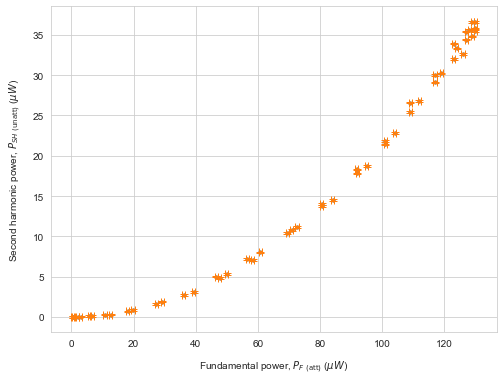

In [53]:
df = pd.read_csv('../data/SHpowvsfundpowextracted.csv',delimiter=',', header=0)
#read all columns data into variables
theta = np.array(df['theta'])
theta_err = np.array(df['delta theta'])
sh_pow = np.array(df['P_sh [muW]'])
sh_pow_err = np.array(df['delta P_sh'])
fund_pow = np.array(df['P_fund (muW)'])
fund_pow_err = np.array(df['delta P_fund'])
plt.figure(figsize=(8, 6))
plt.ylabel(r"Second harmonic power, $P_{SH\ (\rm{unatt})}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Fundamental power, $P_{F\ (\rm{att})}$ ($\mu W$)", labelpad=10)
plt.plot(fund_pow, sh_pow,'.')
plt.errorbar(fund_pow, sh_pow, yerr = sh_pow_err, xerr = fund_pow_err, fmt = ".", label = 'data', capsize = 4)
plt.show()

### Parabolic fit model:

$P_{SH}=aP_{F}^{2}+bP_{F}+c$

In [54]:

def parabolic_model(pf, a, b, c):
    squpart = a*(pf**2)
    linpart = b*pf
    para = squpart + linpart + c
    return para

'''
def parabolic_model(pf, a, b, c):
    para = a*(pf**b)+c
    return para
'''

'\ndef parabolic_model(pf, a, b, c):\n    para = a*(pf**b)+c\n    return para\n'

### Fitting data with parabolic model:

In [55]:
popt, pcov = curve_fit(parabolic_model, fund_pow, sh_pow, sigma = sh_pow_err, p0=[1/500,0,0], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1],"c=",popt[2])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1],"delta_c=",perr[2])

Optimal parameters: a= 0.002165742673060732 b= -0.003090045449298288 c= 0.05628853399202049
Errors in optimal parameters: delta_a= 9.39881987438545e-06 delta_b= 0.0013179739037643685 delta_c= 0.03671799311774581


In [56]:
print("Reduced chi squared =", redchi2(parabolic_model, fund_pow, sh_pow, sh_pow_err, popt[0], popt[1], popt[2]))

Reduced chi squared = 24.420235501638896


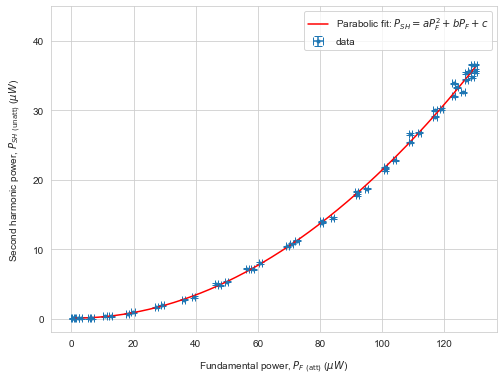

In [57]:
a_opt, b_opt, c_opt = popt
a_err, b_err, c_err = perr
x_model = np.linspace(min(fund_pow), max(fund_pow), 1000)
y_model = parabolic_model(x_model, a_opt, b_opt, c_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-2, 45)
plt.errorbar(fund_pow, sh_pow, yerr = sh_pow_err, xerr = fund_pow_err, fmt = ".", label = 'data', capsize = 4)
plt.ylabel(r"Second harmonic power, $P_{SH\ (\rm{unatt})}$ ($\mu W$)", labelpad=10)
plt.xlabel(r"Fundamental power, $P_{F\ (\rm{att})}$ ($\mu W$)", labelpad=10)
plt.plot(x_model, y_model, color='r', label= r"Parabolic fit: $P_{SH}=aP_{F}^{2}+bP_{F}+c$")
plt.legend(loc = 'upper right')
plt.savefig('../imagesandplots/shpowvsfundpow.pdf')
plt.show()